# Tutorial 3 - Mouse brain (Spatial MALDI-Visium)

In [1]:
import os
import torch
import scanpy as sc
import importlib
import numpy as np

In [2]:
from COSIE.data_preprocessing import load_data
from COSIE.utils import setup_seed
from COSIE.configure import get_default_config
from COSIE.COSIE_framework import COSIE_model
from COSIE.downstream_analysis import *


config = get_default_config()
setup_seed(config['training']['seed'])


## Load data

In [3]:
file_path = '../../../project/SpatialMultimodal/datasets/Mouse_striatum'

In [4]:
adata1_meta = sc.read_h5ad(os.path.join(file_path, 'V11L12-109_A1/adata_V11L12-109_A1_meta.h5ad'))
adata1_rna  = sc.read_h5ad(os.path.join(file_path, 'V11L12-109_A1/adata_V11L12-109_A1_rna.h5ad'))
adata2_rna  = sc.read_h5ad(os.path.join(file_path, 'V11L12-109_B1/adata_V11L12-109_B1_rna.h5ad'))
adata3_rna  = sc.read_h5ad(os.path.join(file_path, 'V11L12-109_D1/adata_V11L12-109_D1_rna.h5ad'))
adata1_meta, adata1_rna, adata2_rna, adata3_rna

(AnnData object with n_obs × n_vars = 221561 × 1000
     obsm: 'UNI_feature', 'pxl_loc', 'spatial', 'spatial2',
 AnnData object with n_obs × n_vars = 221561 × 3000
     obsm: 'UNI_feature', 'pxl_loc', 'spatial', 'spatial2',
 AnnData object with n_obs × n_vars = 267343 × 3000
     obsm: 'UNI_feature', 'pxl_loc', 'spatial', 'spatial2',
 AnnData object with n_obs × n_vars = 267983 × 3000
     obsm: 'UNI_feature', 'pxl_loc', 'spatial', 'spatial2')

In [5]:
adata1_he = sc.AnnData(X=adata1_rna.obsm['UNI_feature'])
adata2_he = sc.AnnData(X=adata2_rna.obsm['UNI_feature'])
adata1_he.obsm['spatial'] = adata1_rna.obsm['spatial'].copy()
adata2_he.obsm['spatial'] = adata2_rna.obsm['spatial'].copy()
adata1_he, adata2_he

(AnnData object with n_obs × n_vars = 221561 × 2048
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 267343 × 2048
     obsm: 'spatial')

## Define the dictionary structure for input data

Each column denotes one section and None represents that the modality is missing in that section.

In [6]:
data_dict = {
        'RNA': [adata1_rna, adata2_rna, adata3_rna],
        'HE': [adata1_he, adata2_he, None],
        'Metabolite': [adata1_meta, None, None]}

In [7]:
feature_dict, spatial_loc_dict, data_dict_processed = load_data(data_dict, n_comps=50, metacell = True)

Combine adjacent 4 cells into metacell to save memory and speed up computation
-------- Processing shared modality RNA across sections --------
Running Harmony for RNA


2025-05-27 13:39:40,513 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-27 13:39:59,698 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-27 13:40:01,518 - harmonypy - INFO - Iteration 1 of 10
2025-05-27 13:42:43,745 - harmonypy - INFO - Iteration 2 of 10
2025-05-27 13:44:56,028 - harmonypy - INFO - Iteration 3 of 10
2025-05-27 13:46:48,375 - harmonypy - INFO - Converged after 3 iterations


-------- Processing shared modality HE across sections --------
Running Harmony for HE


2025-05-27 13:47:33,632 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-27 13:47:44,202 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-27 13:47:45,426 - harmonypy - INFO - Iteration 1 of 10
2025-05-27 13:48:41,775 - harmonypy - INFO - Iteration 2 of 10
2025-05-27 13:49:37,739 - harmonypy - INFO - Iteration 3 of 10
2025-05-27 13:50:36,097 - harmonypy - INFO - Iteration 4 of 10
2025-05-27 13:51:43,308 - harmonypy - INFO - Iteration 5 of 10
2025-05-27 13:52:28,452 - harmonypy - INFO - Converged after 5 iterations


-------- Processing unique modality Metabolite for section 1 --------
Extracting spatial location for section 1
Extracting spatial location for section 2
Extracting spatial location for section 3


## Specify the linkage indicator

COSIE requires a indicator dictionary to specify the cross-section linkage used during training.

In [9]:
Linkage_indicator = {
        ('s1', 's2'): [('RNA', 'RNA')],
        ('s1', 's3'): [('RNA', 'RNA')],
        ('s2', 's3'): [('RNA', 'RNA')],
    }

## Define COSIE Model and Perform Integration

After training, embeddings will be saved to `file_path` in `.npy` format.

In [10]:
model = COSIE_model(config, feature_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['lr'])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

All modalities: ['RNA', 'HE', 'Metabolite']
-------- Encoder description --------
Encoder [RNA]: Input 50 → Hidden [256, 128]
Encoder [HE]: Input 50 → Hidden [256, 128]
Encoder [Metabolite]: Input 50 → Hidden [256, 128]
-------- Dual prediction module description --------
Predictor [RNA → HE]: [128, 512, 512, 128]
Predictor [HE → RNA]: [128, 512, 512, 128]
Predictor [RNA → Metabolite]: [128, 512, 512, 128]
Predictor [Metabolite → RNA]: [128, 512, 512, 128]
Predictor [HE → Metabolite]: [128, 512, 512, 128]
Predictor [Metabolite → HE]: [128, 512, 512, 128]
Using device: cuda:0


In [11]:
final_embeddings = model.train_model(file_path, config, optimizer, device, feature_dict, spatial_loc_dict, 
                                     data_dict_processed, Linkage_indicator)

-------- Running Full-graph training mode --------
Computing linkage between RNA (s1) and RNA (s2)
Computing linkage between RNA (s1) and RNA (s3)
Computing linkage between RNA (s2) and RNA (s3)
Model moved to cuda:0!
-------- Construction of input graphs --------
-------- Constructing spatial graph for s1 --------
Constructing feature graph for [s1 - RNA]...
Constructing feature graph for [s1 - HE]...
Constructing feature graph for [s1 - Metabolite]...
-------- Constructing spatial graph for s2 --------
Constructing feature graph for [s2 - RNA]...
Constructing feature graph for [s2 - HE]...
-------- Constructing spatial graph for s3 --------
Constructing feature graph for [s3 - RNA]...
Training started!


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 600/600 [06:43<00:00,  1.49it/s]


Running Evaluation...
Mapping metacell embedding back to original cells for Section s1 using modality [RNA]
Missing modality [Metabolite] in Section [s2]
Using predictor [RNA → Metabolite] to recover missing embedding...
Using predictor [HE → Metabolite] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s2 using modality [RNA]
Missing modality [HE] in Section [s3]
Using predictor [RNA → HE] to recover missing embedding...
Missing modality [Metabolite] in Section [s3]
Using predictor [RNA → Metabolite] to recover missing embedding...
Mapping metacell embedding back to original cells for Section s3 using modality [RNA]
All embeddings have been saved to ../../../project/SpatialMultimodal/datasets/Mouse_striatum


## Perform clustering and visualization

Perform joint clustering...


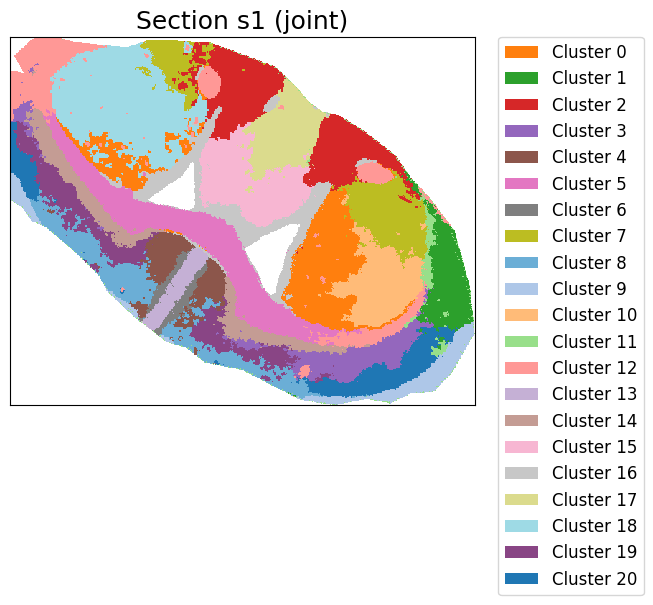

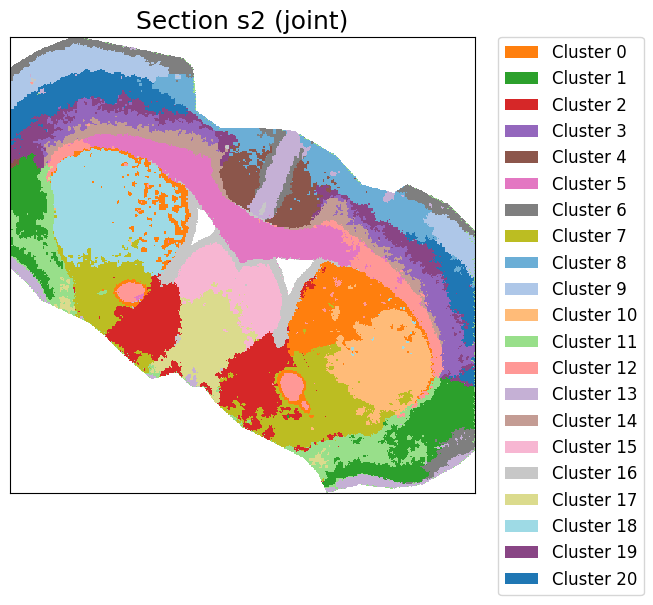

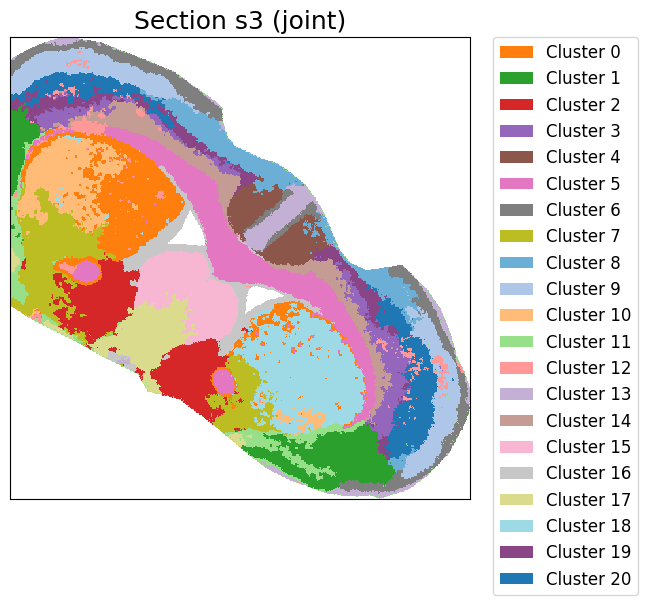

In [12]:
color_map =  [[255,127,14],[44,160,44],[214,39,40],[148,103,189],
              [140,86,75],[227,119,194],[127,127,127],[188,189,34],
             [107,174,214] ,[174,199,232],[255,187,120],[152,223,138],
              [255,152,150],[197,176,213],[196,156,148],[247,182,210],
              [199,199,199],[219,219,141],[158,218,229], [137,69,133],
              [31, 119, 180],[135, 206, 250]]


cluster_label = cluster_and_visualize_superpixel(final_embeddings, 
                                                 data_dict,
                                                 n_clusters=21,
                                                 mode="joint", 
                                                 vis_basis="spatial",  
                                                 colormap = color_map, 
                                                 offset = True,
                                                 swap_xy=True, 
                                                 dpi = 500,
                                                 figscale = 100)

## Predict metabolites data for Section2 and Section3

In [22]:
adata2_meta_predicted = perform_prediction(data_dict,
    final_embeddings,
    target_section = 's2',
    target_modality = 'Metabolite',
    K_num=500,
    target_molecules='All',
    )

Using modality [RNA] in section [s2] as spatial/obs reference
[Metabolite] exists in ['s1'], which will be used as source data section


In [23]:
adata2_meta = sc.read_h5ad(os.path.join(file_path, 'V11L12-109_B1/adata_V11L12-109_B1_meta.h5ad'))
adata2_meta

AnnData object with n_obs × n_vars = 267343 × 1000
    obsm: 'UNI_feature', 'pxl_loc', 'spatial', 'spatial2'

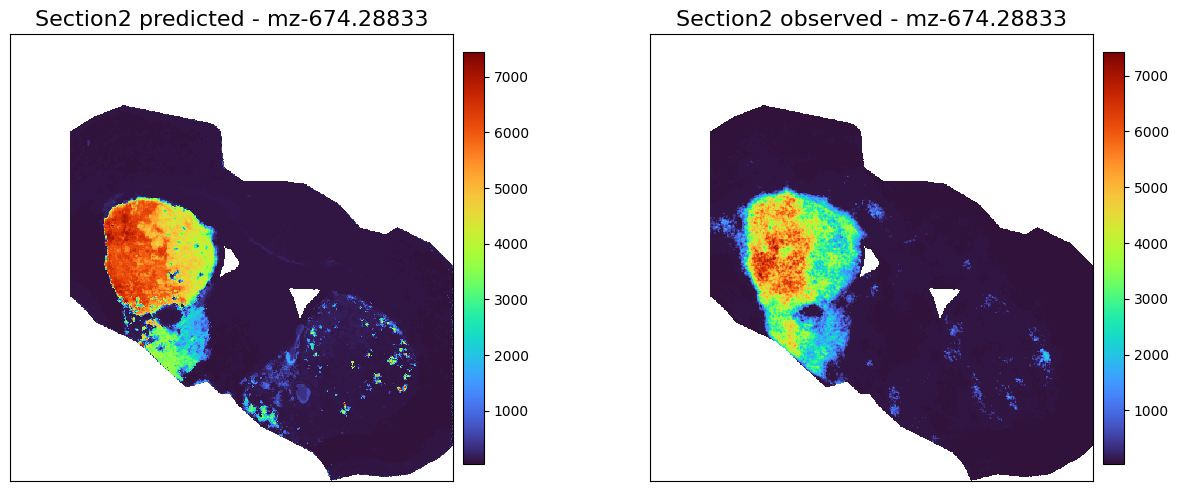

In [24]:
chosed_metabolite = 'mz-674.28833'
plot_marker_comparison_superpixel(chosed_metabolite, 
                       adata2_meta_predicted, 
                       adata2_meta, 
                       'Section2 predicted', 
                       'Section2 observed',
                        swap_xy=True, 
                        figscale = 100,)

In [27]:
adata3_meta_predicted = perform_prediction(data_dict,
    final_embeddings,
    target_section = 's3',
    target_modality = 'Metabolite',
    K_num=500,
    target_molecules='All',
    )

Using modality [RNA] in section [s3] as spatial/obs reference
[Metabolite] exists in ['s1'], which will be used as source data section


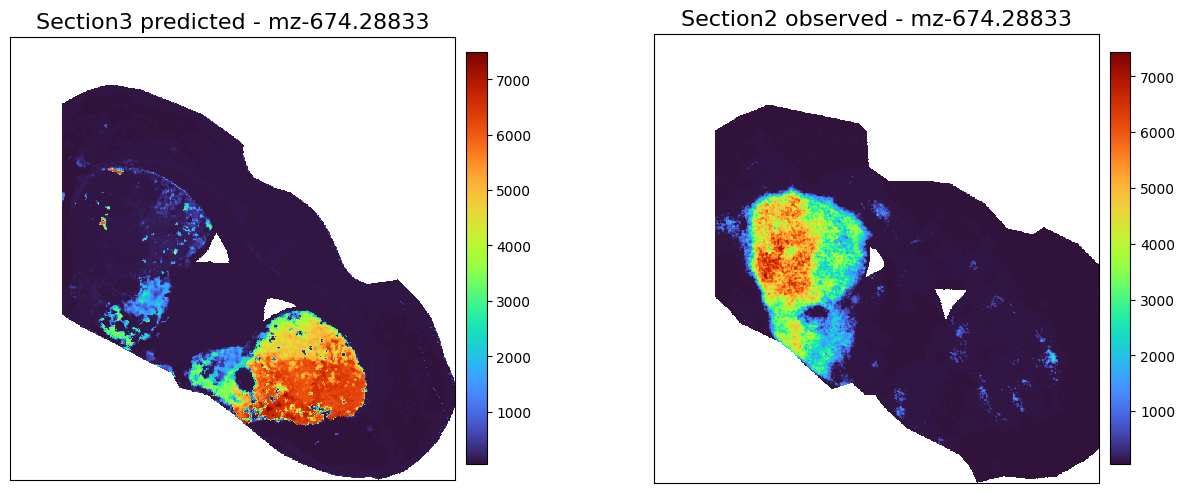

In [28]:
chosed_metabolite = 'mz-674.28833'
plot_marker_comparison_superpixel(chosed_metabolite, 
                       adata3_meta_predicted, 
                       adata2_meta, 
                       'Section3 predicted', 
                       'Section2 observed',
                        swap_xy=True, 
                        figscale = 100,)
